In [1]:
import pandas as pd
import os
import numpy as np
import logging
import sys
import torch
import copy
import yaml
import random

from prediction_utils.pytorch_utils.metrics import (
    StandardEvaluator,
    FairOVAEvaluator,
    CalibrationEvaluator
)

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_style("ticks")

grp_label_dict = {1: 'Black women', 2: 'White women', 3: 'Black men', 4: 'White men'} 

args = {'cohort_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts/cohort/all_cohorts.csv',
        'base_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts',
        'grp_label_dict': {1: 'Black women', 2: 'White women', 3: 'Black men', 4: 'White men'},
        'plot_path': os.path.join('/labs/shahlab/projects/agataf/fairness_utility/eval/plots', 'paper_plots'),

       }

output_path = os.path.join(args['plot_path'], 'risk_category_counts.png')


In [2]:
def get_frac_treated(df, args):
    num_treated_by_stratum = (df
         .query('(phase=="test") ')
         .filter(['group', 'treat', 'person_id', 'model_id', 'model_type', 'labels'])
         .groupby(['model_type', 'model_id', 'group', 'labels', 'treat'])
         .count()
        )

    num_per_stratum = (df
          .query('(phase=="test") ')

               .filter(['group', 'person_id', 'model_type', 'model_id', 'labels'])
               .groupby(['model_type', 'model_id',  'group', 'labels'])
               .count()
         )

    frac_treated = num_treated_by_stratum.div(num_per_stratum)

    frac_treated = (frac_treated
                    .reset_index()
                    .assign(group = lambda x: x.group.map(args['grp_label_dict']),
                            labels = lambda x: x.labels.map({0: ' individuals with \nno ASCVD event',
                                                             1: 'individuals with \n  ASCVD event'}))
                    .rename(columns={'person_id': 'fraction'})
                   )
    return frac_treated

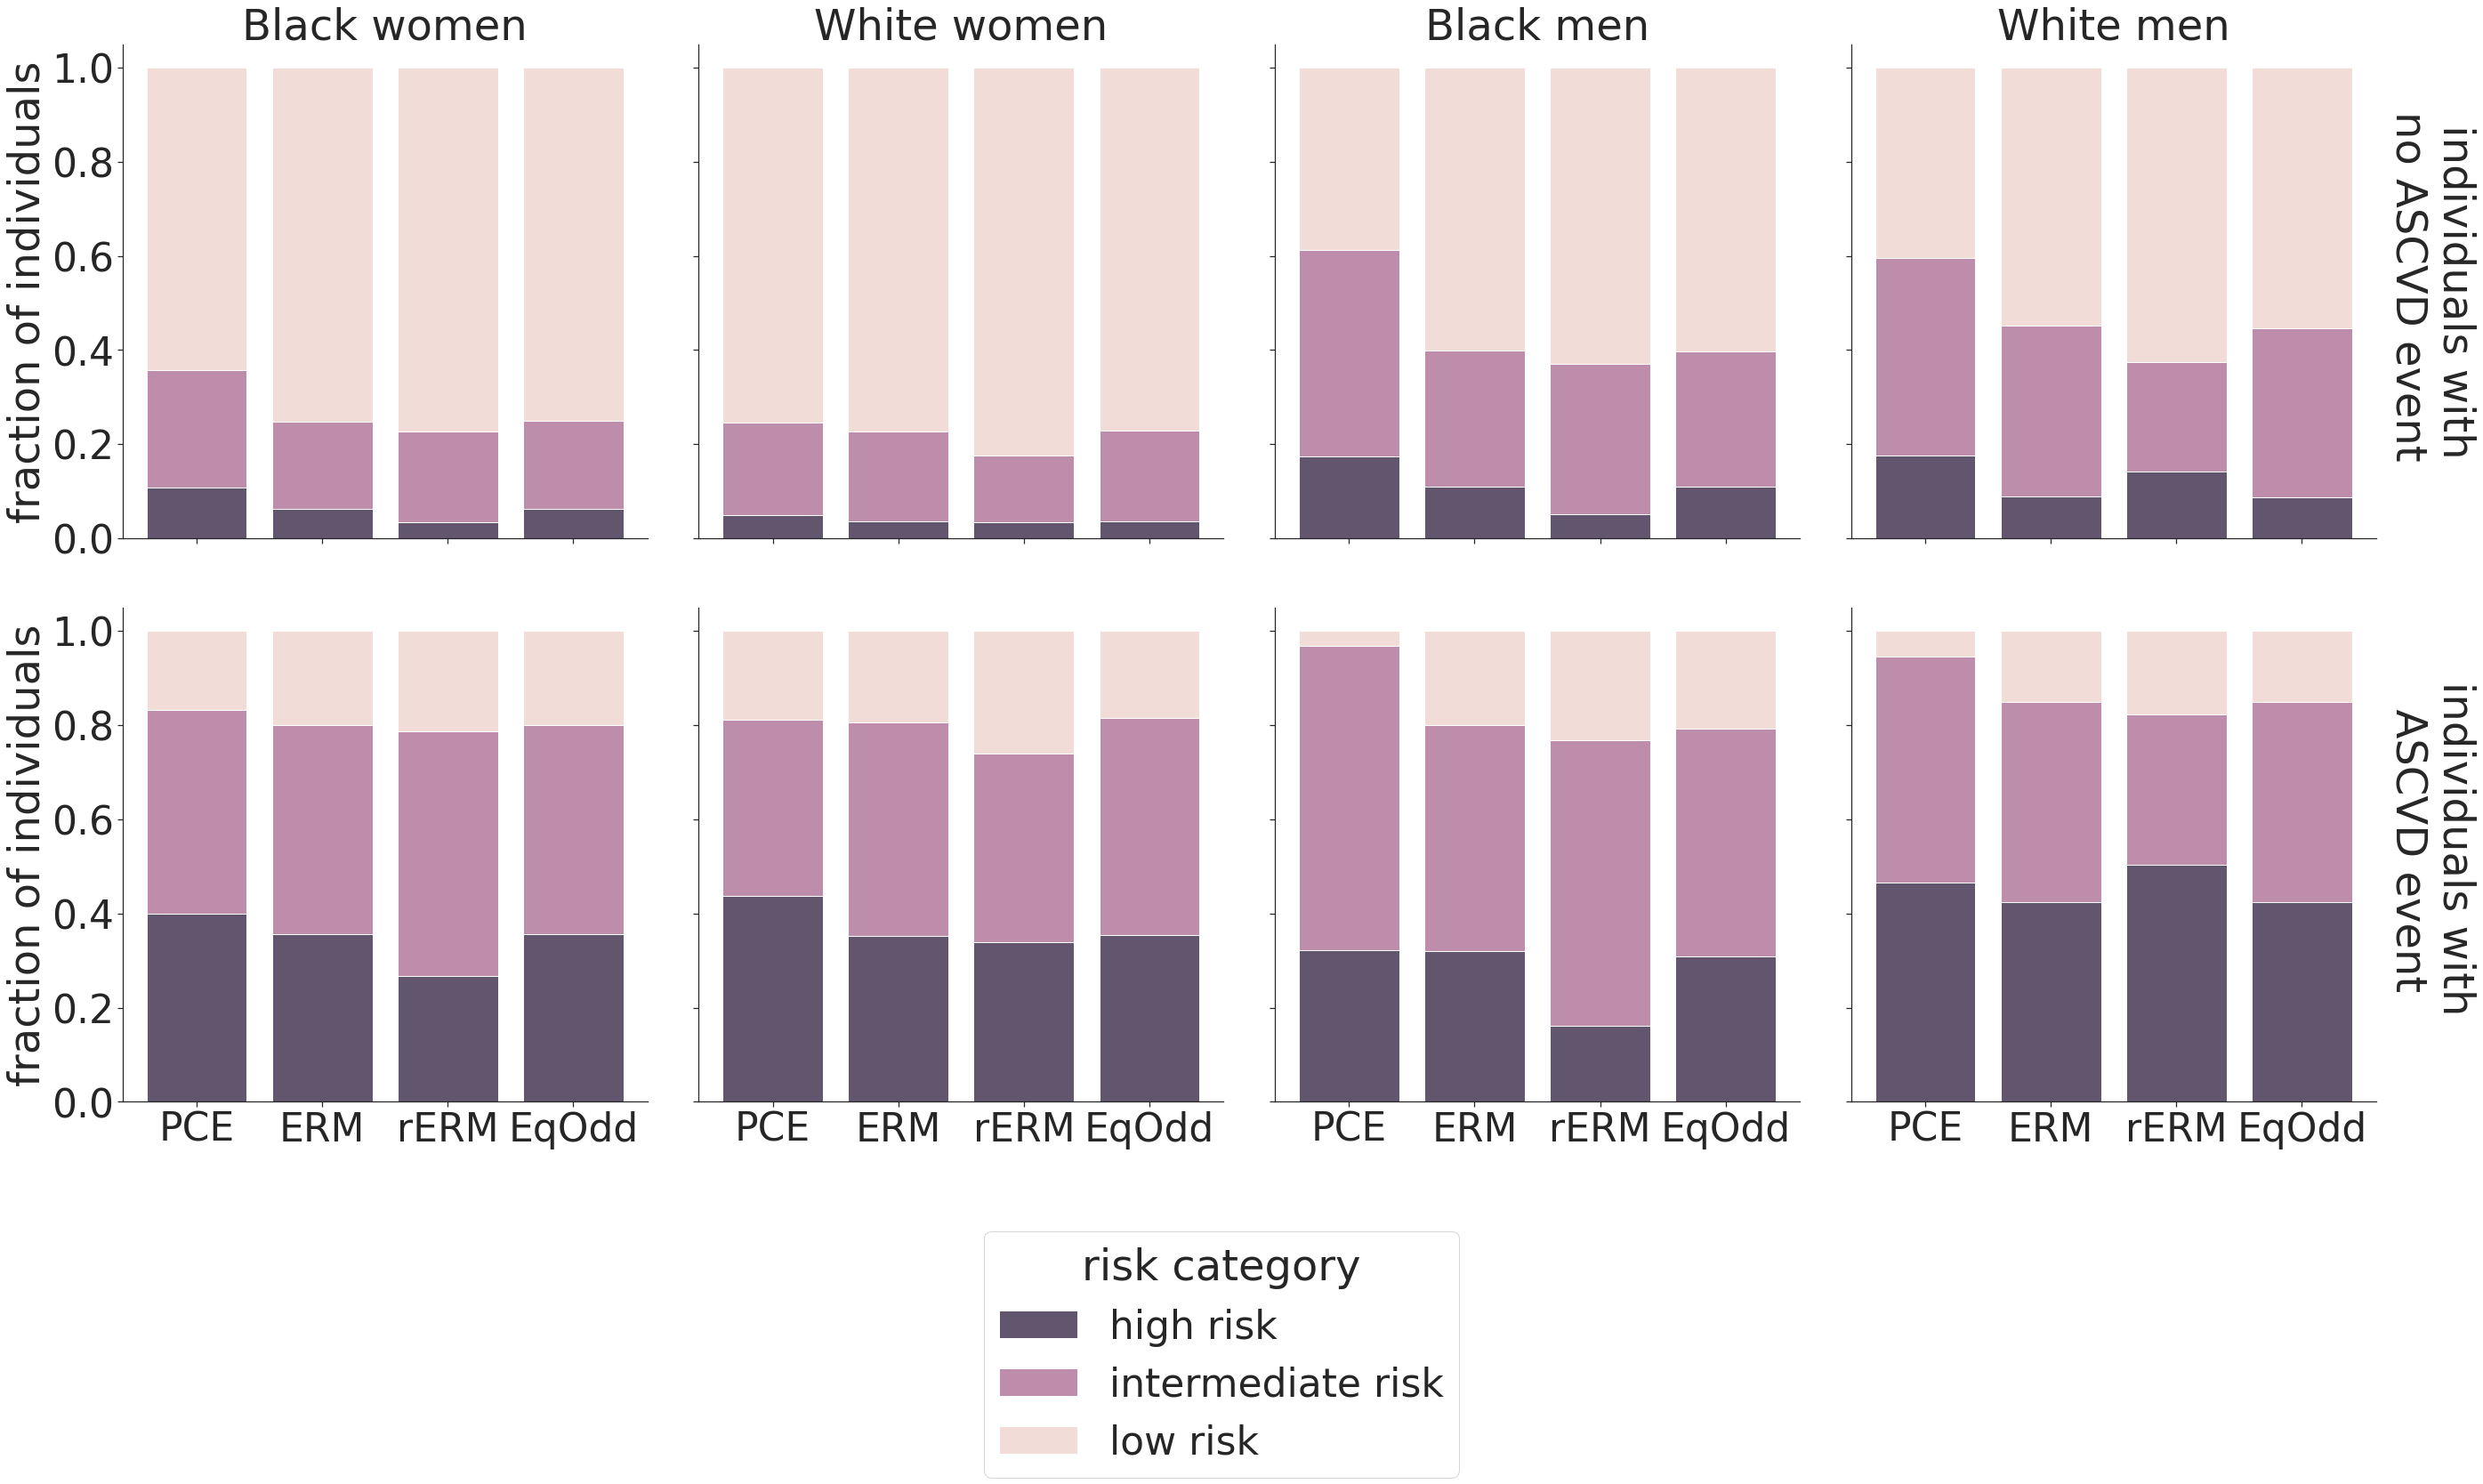

In [3]:
frac_treated_all = []
eqodds_threshold = 0.01
for experiment in ['original_pce', 'apr14_erm', 'apr14_erm_recalib', 'apr14_mmd']:

    aggregate_path = os.path.join(args['base_path'], 'experiments', 
                                      experiment, 'performance',
                                      'all')
    preds_path = os.path.join(aggregate_path, 'predictions.csv')
    preds = pd.read_csv(preds_path)
    
    if experiment in ['apr14_mmd', 'apr14_thr']:
        preds = preds.query('model_id == @eqodds_threshold')
        
    if 'model_id' not in preds.columns:
        preds = preds.assign(model_id=0)
        
    frac_treated = get_frac_treated(preds, args)  
    frac_treated_all.append(frac_treated)

frac_treated_all = (pd
                    .concat(frac_treated_all)
                    .assign(model_type = lambda x: x.model_type.map({'original_pce': 'PCE',
                                                                     'erm': 'ERM',
                                                                     'recalib_erm': 'rERM',
                                                                     'eqodds_mmd': 'EqOdd'}
                                                                   )
                           )
                   )



sns.set(font_scale=4)
sns.set_style("ticks")


g = sns.displot(
    frac_treated_all,
    x='model_type',
    col="group", 
    row='labels', 
    hue="treat", 
    weights='fraction', 
    shrink=0.8, 
    multiple='stack',
    height=10, 
    bins=len(frac_treated_all.model_type.unique()), 
    hue_order=['0','1','2',], 
    legend=False, #stat='frequency', 
    facet_kws = {'margin_titles': True}
)

plt.legend(title='risk category',
           loc='lower center', 
           labels=['high risk', 'intermediate risk', 'low risk'],
          # bbox_to_anchor=(1.07, 1)
           bbox_to_anchor=(-1.2, -0.8)
          )

(g.set_xlabels('')
 .set_ylabels('fraction of individuals')
 .set_titles(row_template="{row_name}", col_template="{col_name}")
)

sns.set(font_scale=1)

if output_path is not None:
    g.savefig(output_path)
    